In [ ]:
!pip install nltk
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from gensim.models.phrases import Phraser
from gensim.models import Word2Vec
from gensim.models import Phrases
from nltk.corpus import stopwords
import gensim.downloader as api
import matplotlib.pyplot as plt
from google.colab import drive
import pandas as pd
import numpy as np
import gensim
import nltk
import os
import re

nltk.download('stopwords')
nltk_stopwords = stopwords.words('english')
drive.mount('/content/drive')
dir = '/content/drive/MyDrive/Panasonic/'
os.chdir(dir)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Mounted at /content/drive


In [ ]:
df = pd.read_excel('clients.xlsx')
desc = df['Company Description / Use Case']
desc.dropna(axis=0, inplace=True)

companies = df['Manual']
companies.dropna(axis=0, inplace=True)
companies = companies.apply(lambda x:x.lower()).unique().tolist()

In [ ]:
def clean_str(s):
    s = s.strip().lower()
    s = re.sub(r'[^%.\w\s]|_', ' ', s)
    s = re.sub(' +', ' ', s)

    return s

In [ ]:
sentences = []
for d in desc:
    sents = clean_str(d).split('.')
    for sent in sents:
        #sent = [word for word in sent.split() if len(word) > 1]
        sent = [word for word in sent.split() if word not in nltk_stopwords and len(word) > 1]
        if len(sent) > 2:
            sentences.append(sent)

In [ ]:
bigrams = Phrases(sentences, min_count=2, threshold=2, delimiter=b'_')
bigram_text = [bigrams[sentence] for sentence in sentences]

trigrams = Phrases(bigram_text, min_count=2, threshold=2)
trigram_text = [trigrams[sentence] for sentence in bigram_text]

sentences = trigram_text

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
text8 = api.load('text8')
model = Word2Vec(text8, min_count=25, window=2, sg=1)

[==================================================] 100.0% 31.6/31.6MB downloaded


In [ ]:
model.build_vocab(sentences, update=True)
model.train(sentences, total_examples=len(sentences), epochs = 15)

(127196, 228105)

In [ ]:
# SAVE model
model.wv.save('vectors.kv')

In [ ]:
# SAVE model
model = gensim.models.KeyedVectors.load('vectors.kv')

In [ ]:
def vector_mean(model, pos, neg=[]):
    size = (len(pos) + len(neg))
    st = 0
    mean_vec = None
    while not mean_vec:
        try:
            mean_vec = np.copy(model[pos[st]])
            break
        except:
            st += 1
            size -= 1

        if not size:
            return []

    for pos_word in pos[st:]:
        try:
            mean_vec += model[pos_word]
        except:
            size -= 1

    for neg_word in neg:
        try:
            mean_vec -= model[neg_word] 
        except:
            size -= 1

    mean_vec /= size
    
    return mean_vec

def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.sqrt(np.dot(v1, v1)) * np.sqrt(np.dot(v2, v2)))

In [ ]:
# use similarity vectors to remove irrelevant terms
neg_words=['pharmaceutical', 'farmers', 'microprocessors', 'retailer', 'automation', 'surveying', 'warehouses', 'telecommunications', 'broadband', 'logistics', 'navigating', 'indoor', 'customer', 'experience', 'airport', 'malls', 'shopping']

vec_misc = vector_mean(model, pos=['in_the', 'is_the', 'with_the', 'also', 'including', 'since', 'it_is', 'based_on', 'like', 'via'], neg=neg_words)
vec_verbs = vector_mean(model, pos=['owned', 'specialized', 'provides', 'create', 'develop', 'offers', 'support', 'research', 'use', 'produce'], neg=neg_words)
vec_nouns = vector_mean(model, pos=['technology', 'clients', 'solution', 'business', 'services', 'company', 'industry', 'platform', 'products', 'group', 'people', 'market', 'world', 'corporation', 'applications', 'community', 'project', 'staff', 'experts'], neg=neg_words)
vec_adjs = vector_mean(model, pos=['leading', 'custom', 'best', 'top', 'innovative', 'comprehensive', 'first', 'fully', 'functioning', 'unique'], neg=neg_words)

def relevancy(word, thresholds):
    vec_word = vector_mean(model, pos=[word])
    #print(cosine_similarity(vec_word, vec_misc), thresholds[0])
    #print(cosine_similarity(vec_word, vec_verbs), thresholds[1])
    #print(cosine_similarity(vec_word, vec_nouns), thresholds[2])
    #print(cosine_similarity(vec_word, vec_adjs), thresholds[3])

    try:
        if cosine_similarity(vec_word, vec_misc) > thresholds[0]:
            return False
    except:
        pass
    try:
        if cosine_similarity(vec_word, vec_verbs) > thresholds[1]:
            return False  
    except:
        pass
    try:
        if cosine_similarity(vec_word, vec_nouns) > thresholds[2]:
            return False
    except:
        pass
    try:
        if cosine_similarity(vec_word, vec_adjs) > thresholds[3]:
            return False
    except:
        pass

    return True

In [ ]:
model.wv.most_similar(positive=[vec_nouns], topn=5000)[4000:5000]

In [ ]:
freq = {}

for sent in sentences:
    for word in sent:
        if word not in freq:
            freq[word] = 0
        freq[word] += 1

#for word in freq:
#    print(word, freq[word])

In [ ]:
thresholds = [-0.55, -0.5, 0.22, -0.3]
x, y = [], []
for key, val in sorted(freq.items(), key=lambda kv: kv[1], reverse=True):
    if val >= 2 and \
       key not in nltk_stopwords and \
       relevancy(key, thresholds) and \
       not key.isdigit() and \
       key not in companies:
        x.append(key)
        y.append(val)

x_sorted = [x_elem for _,x_elem in sorted(zip(y,x))]
y_sorted = sorted(y)

In [ ]:
df_freq = pd.DataFrame({'word':x_sorted, 'freq':y_sorted})
df_freq.to_csv('freq_list.csv', index=False)

(420, 22)
(134, 22)


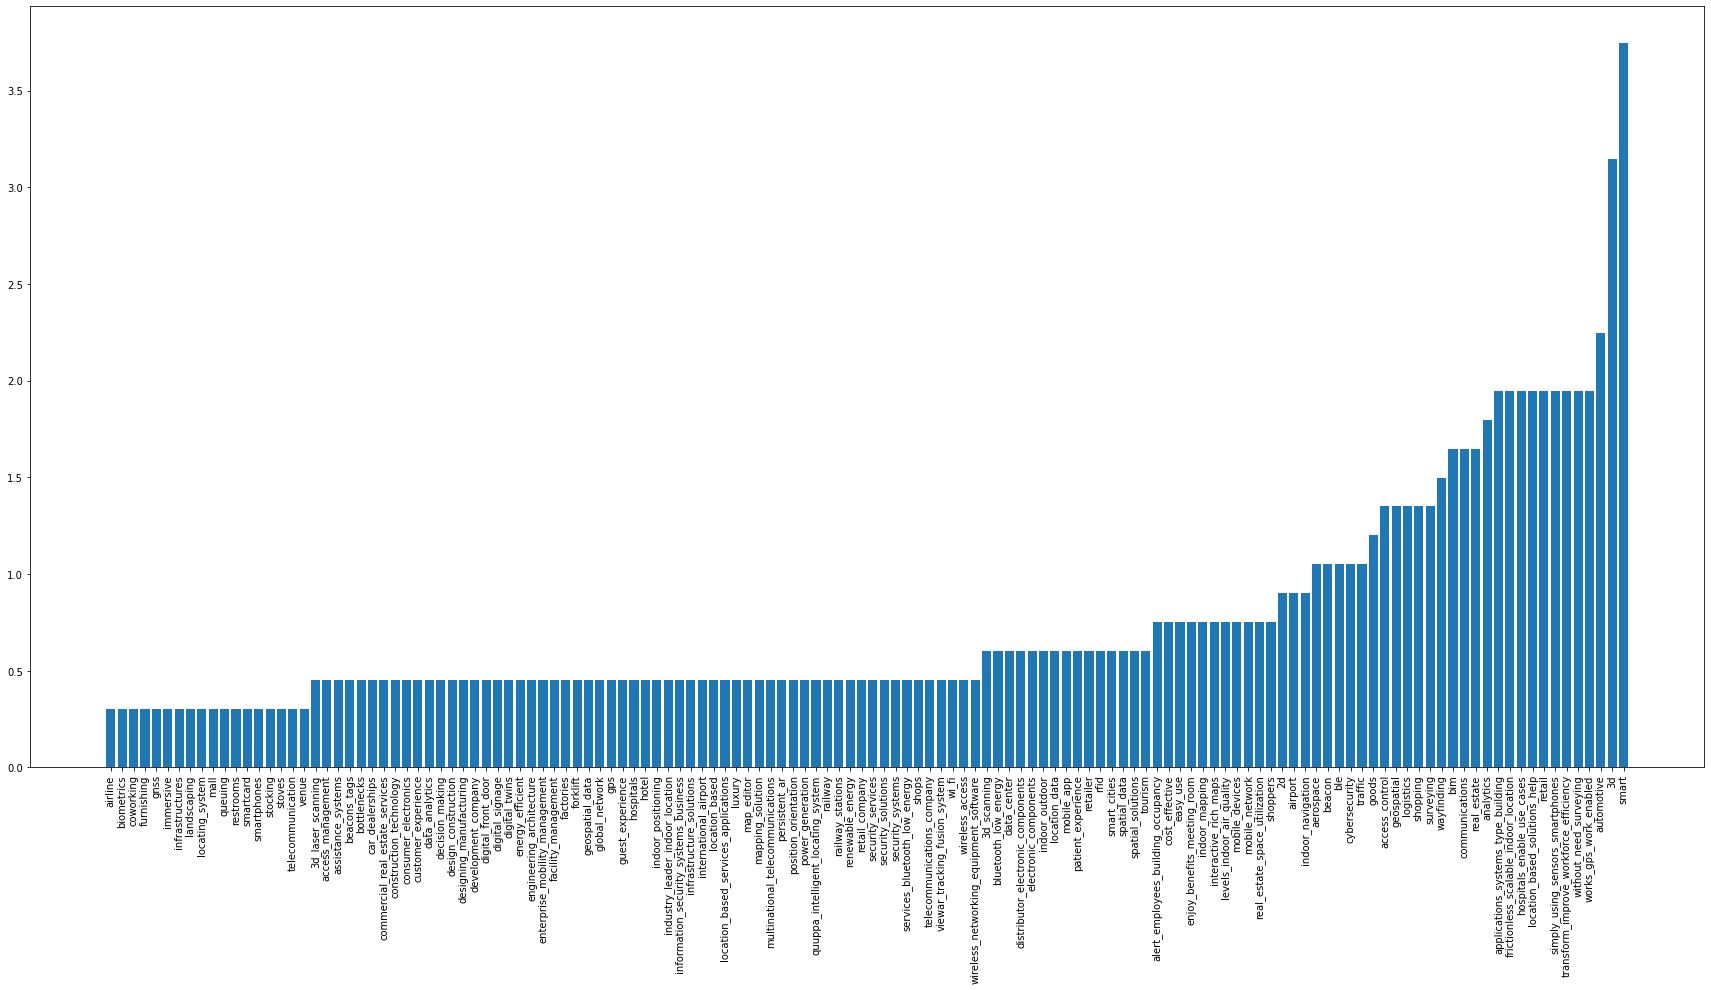

In [ ]:
df_freq_clean = pd.read_csv('freq_list.csv')
print(df_freq_clean.shape)

unique_terms = []
drop_idx = []
for i, row in df_freq_clean.iterrows():
    word = row['word']
    if row['remove'] == 1:
        drop_idx.append(i)
    else:
        # remove plural duplicates
        if word[-1] == 's':
            word = word[:-1]

        word = word.replace('_', '')

        if word in unique_terms:
            drop_idx.append(i)
        else:
            unique_terms.append(word)

df_freq_clean.drop(drop_idx, axis=0, inplace=True)
print(df_freq_clean.shape)
total_freq_count = sum(df_freq_clean['freq'].tolist())

fig = plt.figure(figsize=(30, 14))
plt.bar(df_freq_clean['word'].tolist(), (100 * df_freq_clean['freq'] / total_freq_count).tolist())
plt.xticks(rotation=90)

plt.show()

In [ ]:
def camelcase(s):
    s = s.split()
    for i in range(len(s)):
        first = s[i][0]
        if 65 <= ord(first) <= 90:
            continue
        elif 97 <= ord(first) <= 122:
            s[i] = chr(ord(first)-32) + s[i][1:]

    return ' '.join(s)

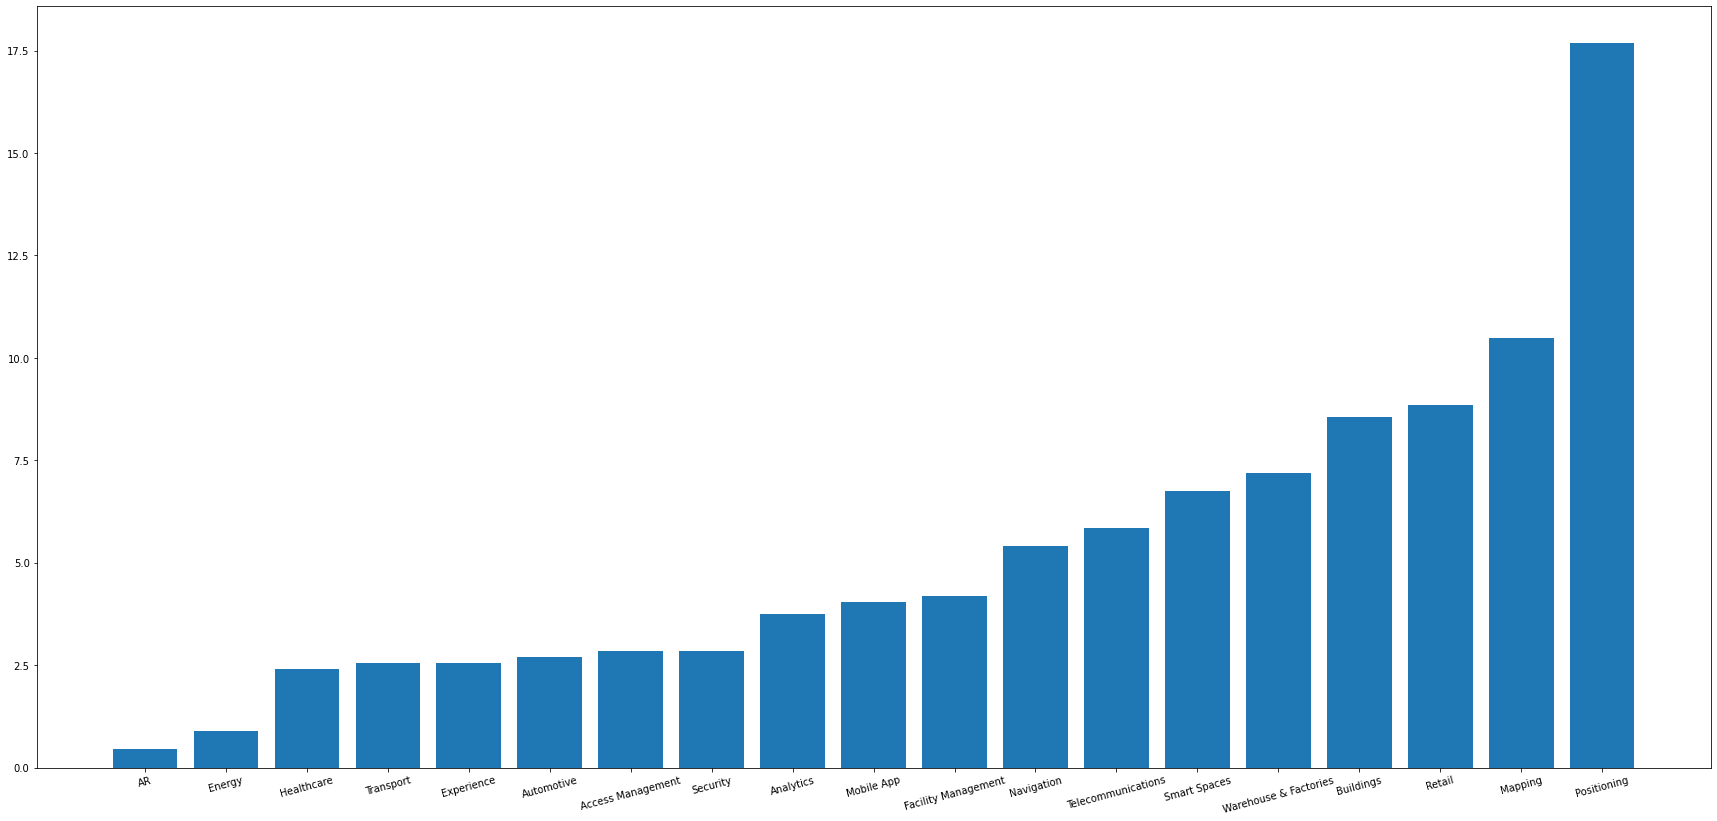

In [ ]:
cats = {}
cols = df_freq_clean.columns[3:]
for col in cols:
    cats[col] = 0

for i, row in df_freq_clean.iterrows():
    for col in cols:
        if row[col] == 1:
            cats[col] += row['freq']

total_count = sum(list(map(lambda x:cats[x], list(cats.keys()))))

x = []
y = []
for key in sorted(cats, key=cats.get):
    x.append(camelcase(key))
    y.append(100*cats[key]/total_count)

fig = plt.figure(figsize=(30, 14))
plt.bar(x, y)
plt.xticks(rotation=15)

plt.show()

In [ ]:
word = 'automotive'
print(cosine_similarity(vec_misc, vector_mean(model, pos=[word])), thresholds[0])
print(cosine_similarity(vec_verbs, vector_mean(model, pos=[word])), thresholds[1])
print(cosine_similarity(vec_nouns, vector_mean(model, pos=[word])), thresholds[2])
print(cosine_similarity(vec_adjs, vector_mean(model, pos=[word])), thresholds[3])

print(relevancy(word, thresholds))
print(freq[word])
print(word not in companies)

-0.6998442 -0.55
-0.528737 -0.5
0.2196115 0.22
-0.5305495 -0.3
True
15
True


In [ ]:
'''
freq = {}

for sent in sentences:
    for word in sent:
        if word not in freq:
            freq[word] = 0
        freq[word] += 1

x, y = [], []
for sets in [
    ['automotive', 'automobile', 'automaker', 'automakers', 'cars', 'car', 'transport', 'transportation', 'motorcycle', 'buses', 'bus', 'traffic'],
    ['energy', 'fuel', 'solar', 'wind', 'hydroelectric','electric', 'electricty' ,'diesel', 'petrol', 'gas', 'oil', 'clean', 'nuclear'],
    ['industrial', 'factory', 'factories', 'machines', 'machine', 'manufcaturing', 'semiconductor', 'hardware'],
    ['network', 'networks', 'wireless', '5g', '4g'],
    ['healthcare', 'health', 'hospital', 'hospitals', 'nurse', 'nurses', 'doctor', 'doctors', 'wards'],
    ['education', 'school', 'schools', 'teacher', 'teachers'],
    ['survey', 'surveying', 'lidar', 'outdoor', 'outdoors', 'geomatics', 'geography'],
    ['indoor positioning', 'indoor', 'indoors', 'positioning', 'navigation', 'wayfinding'],
    ['digital twin', 'twin', 'twins', 'simulation'],
    ['bim', 'building'],
    ['construction', 'renovation', 'architecture', 'architectural', 'structural', 'structure', 'structures', 'building', 'build', 'maintenance'],
]:

    x.append(sets[0])
    y.append(0)
    for item in sets:
        if item in freq:
            y[-1] += freq[item]

    print(x[-1], y[-1])
'''

In [ ]:
'''
x, y = [], []
for sets in [
    ['airport', 'airports'],
    ['hospital', 'hospitals', 'clinic', 'clinics', 'ward', 'wards', 'nurse', 'nurses'],
    ['clean energy', 'sustainable', 'sustainability', 'clean', 'renewable', 'environment'],
    ['nuclear', 'uranium'],
    ['factory', 'factories', 'manufacturing', 'manufacture', 'manufacturer', 'packaging'],
    ['autonomous driving', 'autonomous', 'driverless'],
    ['space exploration', 'planet', 'exploration'],
    ['imaging', 'vision', 'image'],
    ['smart space', 'smart'],
    ['entertainment'],
    ['AR/VR', 'ar', 'vr'],
    ['logistics', 'supply'],
    ['real estate', 'estate'],
    ['shopping malls', 'mall', 'malls'],
    ['security', 'protection', 'alarm', 'defence', 'defences', 'missile', 'missiles']
]:

    x.append(sets[0])
    y.append(0)
    for item in sets:
        if item in freq:
            y[-1] += freq[item]

    print(x[-1], y[-1])
'''